In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import corner
import matplotlib as mpl
%matplotlib inline

In [17]:
def set_ticklabels(ax, size=18):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(size)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(size)
        label_y.set_family('serif')

In [54]:
def main_halos(snap_data):
    sorted_vmax = snap_data['vmax']
    sorted_vmax = np.sort(sorted_vmax)
    v_max_A = sorted_vmax[-1]
    v_max_B = sorted_vmax[-2]
    v_max_C = sorted_vmax[-3]
    ii = snap_data['vmax']==v_max_A
    jj = snap_data['vmax']==v_max_B
    #kk = snap_data['vmax']==v_max_C
    index = (ii | jj)
    #print sorted_vmax[-3::]
    main_halos_data = snap_data[index]
    if(main_halos_data['vmax'][0] < main_halos_data['vmax'][1]):
        tmp = main_halos_data[0].copy()
        main_halos_data[0] = main_halos_data[1].copy()
        main_halos_data[1] = tmp.copy()
    return main_halos_data

In [55]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
        
    return snap_data

In [142]:
n_pairs = 53
v_circ_A = np.zeros(n_pairs)
v_circ_B = np.zeros(n_pairs)
v_circ_C = np.zeros(n_pairs)
distance_AB = np.zeros(n_pairs)
velocity_AB = np.zeros(n_pairs)
n_bright = np.zeros(n_pairs)
n_total = np.zeros(n_pairs)
for i in range(n_pairs):
    filename = "../data/dm_selected/Illustris_group_{}.dat".format(i)
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    v_circ_A[i] = main_h_data['vmax'][0]
    v_circ_B[i] = main_h_data['vmax'][1]
    distance_AB[i] =  np.sqrt((main_h_data['x'][0] - main_h_data['x'][1])**2 \
                    + (main_h_data['y'][0] - main_h_data['y'][1])**2 \
                    + (main_h_data['z'][0] - main_h_data['z'][1])**2)
    velocity_AB[i] = np.sqrt((main_h_data['vx'][0] - main_h_data['vx'][1])**2 \
                    + (main_h_data['vy'][0] - main_h_data['vy'][1])**2 \
                    + (main_h_data['vz'][0] - main_h_data['vz'][1])**2)
    
    n_total[i] = len(data)
    ii = data['bmag'] < 0
    n_bright[i] = len(data[ii])
    if((distance_AB[i] > 700.0) & (distance_AB[i]<1400) & (velocity_AB[i]>100.0)):
        print('halo file {}'.format(i))

halo file 4
halo file 7
halo file 8
halo file 12
halo file 15
halo file 20
halo file 21
halo file 29
halo file 35
halo file 39
halo file 42
halo file 46
halo file 52


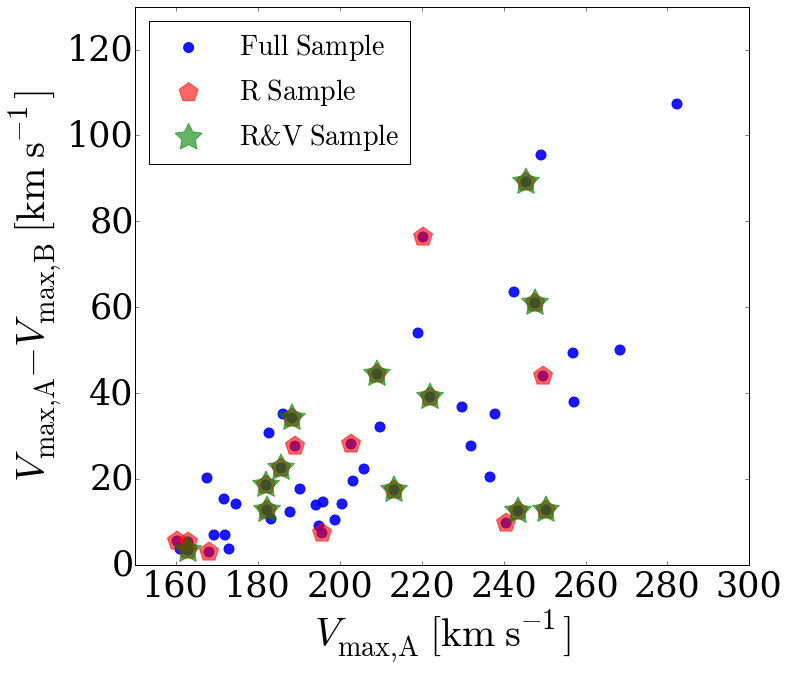

In [153]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

ii = distance_AB > 0
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

ii = (distance_AB > 700.0) & (distance_AB<1400)
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


ii = (distance_AB > 700.0) & (distance_AB<1400) & (velocity_AB>100)
plt.scatter(v_circ_A[ii], v_circ_A[ii] - v_circ_B[ii], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([150,300])
ax.set_ylim([0.0,130])

plt.xlabel(r'$V_{\rm{max,A}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.ylabel(r'$V_{\rm{max,A}} - V_{\rm{max,B}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_circ_pairs.pdf', bbox_inches='tight')

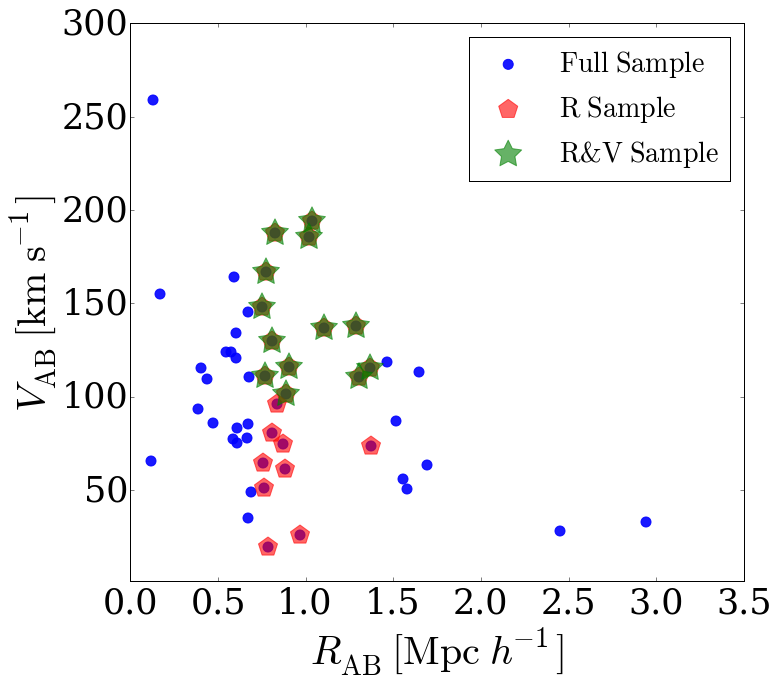

In [154]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

ifull = distance_AB > 0
plt.scatter(distance_AB[ifull]/1000.0, velocity_AB[ifull], label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

irsample = (distance_AB > 700.0) & (distance_AB<1400)
plt.scatter(distance_AB[irsample]/1000, velocity_AB[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


irvsample = (distance_AB > 700.0) & (distance_AB<1400) & (velocity_AB>100)
plt.scatter(distance_AB[irvsample]/1000, velocity_AB[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([0.0,3.5])
ax.set_ylim([1,300])
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'$R_{\rm{AB}} \ [{\rm{Mpc}}\ h^{-1}]$', size=40)
plt.ylabel(r'$V_{\rm{AB}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=1, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_r_pairs.pdf', bbox_inches='tight')

#plt.scatter(distance_AB[ii], velocity_AB[ii])

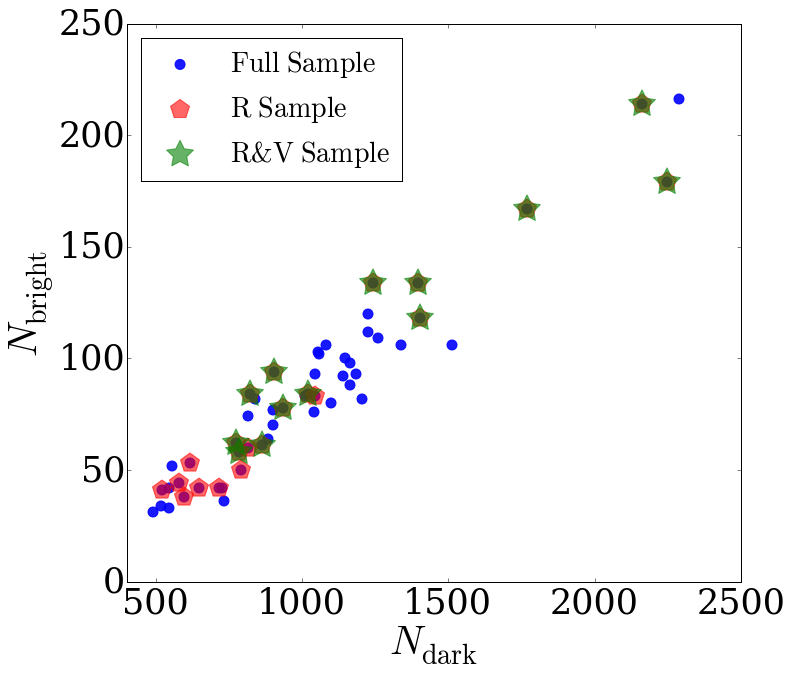

In [168]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_total[ifull], n_bright[ifull],label='$\mathrm{Full\ Sample}$',s=100,alpha=0.9,color='b')

plt.scatter(n_total[irsample], n_bright[irsample], label='$\mathrm{R\ Sample}$',
            s=400,alpha=0.6,color='r', marker=(5,0))


plt.scatter(n_total[irvsample], n_bright[irvsample], label='$\mathrm{R&V\ Sample}$',
            s=800,alpha=0.6,color='green', marker=(5,1))

ax.set_xlim([400,2500])
ax.set_ylim([0,250])
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'$N_{\rm{dark}}$', size=40)
plt.ylabel(r'$N_{\rm{bright}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/n_structure.pdf', bbox_inches='tight')

#plt.scatter(distance_AB[ii], velocity_AB[ii])